In [1]:
if 0: # set to 1 to install MIDI library mido:
    !pip3 install mido

In [2]:
if 0: # set to 1 tom install librosa (for converting midi notes to freq/symbol)
    !pip3 install librosa

(Note: if using datahub, just installing mido didn't seem to let ```import mido``` work on the same session...might need to log out and log back in to restart the Jupyter sever)

In [3]:
import numpy as np
import mido
import os

print('Importing mido from path:', mido.__file__)

Importing mido from path: /opt/anaconda3/lib/python3.9/site-packages/mido/__init__.py


List all MIDI files in the imagery dataset:

In [4]:
# !ls data/musicImagery/stimuli

from glob import glob
#mid_files = glob('D:\marion_music_imagery\dryad\original_stim\original_stim\midi\**.mid')
mid_files = glob(os.path.join('data', 'musicImagery', 'stimuli', 'midi', '**.mid'))
for mid_path in mid_files:
    print(mid_path)


data/musicImagery/stimuli/midi/chor-019.mid
data/musicImagery/stimuli/midi/chor-096.mid
data/musicImagery/stimuli/midi/chor-101.mid
data/musicImagery/stimuli/midi/chor-038.mid


In [5]:
def get_midi_events(mid_path, TICKS_PER_BEAT = 480, print_out = False):
    
    """
    This function generates `mid_events`: a dict of tracks in the MIDI file.
    Each track gets a list of `track_events`.
    Each event in `track_events` is formatted as:
        [MIDI note, start time (ms), stop time (ms)]
        
    This has only been tested on MIDI files where only one note is played at one time (no overlapping notes)
    """
    
    # this will become a dict of tracks (with events) in the MIDI file
    mid_events = {}
    
    # Code here is motivated from examples in mido's documentation:
    # (from https://mido.readthedocs.io/en/latest/midi_files.html)
    
    # Open the MIDI file
    mid = mido.MidiFile(mid_path, ticks_per_beat=TICKS_PER_BEAT)
    
    # Iterate through all tracks and collect 
    # - tempo info
    # - note on/off events
    
    for track_idx, track in enumerate(mid.tracks):
        
        if print_out:
            print('Track {}: {}'.format(track_idx, track.name))
            print('-'*50)
        
        # Timekeeper for the MIDI file
        global_ticks = 0
        
        # Container for collecting all note events
        track_events = []
        
        # Read all the messages for the given track
        for msg in track:
            
            if print_out:
                print(msg)
                    
            # Collect time information for this event
            delta_ticks = msg.time
            global_ticks += delta_ticks
            
            # Check if we have tempo information in this message
            if msg.is_meta and msg.type=='set_tempo':
                    
                # https://mido.readthedocs.io/en/latest/midi_files.html#about-the-time-attribute
                MICROS_PER_BEAT = msg.tempo
                
                if print_out:
                    print(f'>> Tempo (µs/beat): {MICROS_PER_BEAT}')
                
            elif msg.type == 'program_change':
                
                if print_out:
                    # This must be a change of program
                    print(f'>> Program: {msg.program}')
                
            elif 'note' in msg.type: # for both ON and OFF note events
                
                # MIDI number for the note
                NOTE = msg.note 
                
                if msg.type == 'note_on':
                    START_TIME_ms = (global_ticks / TICKS_PER_BEAT) * MICROS_PER_BEAT / 1e3
                    event = [NOTE, START_TIME_ms] # note_on event
                    track_events.append(event)
                    
                elif msg.type == 'note_off':
                    STOP_TIME_ms = (global_ticks / TICKS_PER_BEAT) * MICROS_PER_BEAT / 1e3
                    
                    # now find the note to turn off in the transcript
                    # this is overkill for a monophonic stimulus
                    for event in track_events:
                        if (NOTE in event) and (len(event)<3): # missing STOP_TIME_ms
                            if STOP_TIME_ms > event[1]: # STOP_TIME_ms is after START_TIME_ms
                                event.append(STOP_TIME_ms)
                
                if print_out:
                    velocity = msg.velocity # same for all notes in this dataset (100) => ignore

                    if msg.type == 'note_on':
                        msg_time_ms = START_TIME_ms
                    elif msg.type == 'note_off':
                        msg_time_ms = STOP_TIME_ms

                    # get the musical note for this event msg
                    import librosa
                    note_symbol = librosa.midi_to_note(NOTE)
                    note_Hz = librosa.midi_to_hz(NOTE)

                    print('>> {}\t{:.3f} Hz\t{}\t{: 4.1f} ms'.format(
                        note_symbol, 
                        note_Hz,
                        global_ticks,
                        msg_time_ms,
                    )
                         )
            
            elif msg.type == 'end_of_track':
                
                if print_out:
                    print('#Ticks:', global_ticks)
                    print('#Events:', len(track_events))
                    print('End of file')
            
            else: # probably the ending message in the MIDI file
                print('Unhandled event type:', msg.type)
                
        mid_events[track_idx] = track_events
        
    return mid_events

Read the MIDI files:

In [6]:
TICKS_PER_BEAT = 24 # based on time=72 corresponding to first quarter note F4 in chor-038
song_book = {} # collect all midi scores here

for mid_path in mid_files:
    
    # get song name from the filepath
    song_name = mid_path.split('/')[-1]
    song_book[song_name] = {} # for collecting tracks within the MIDI file
    
    print('='*50)
    print(f'Reading {song_name}...')
    song_book[song_name] = get_midi_events(
        mid_path, 
        TICKS_PER_BEAT, 
        print_out = True
    )

Reading chor-019.mid...
Track 0: 
--------------------------------------------------
MetaMessage('set_tempo', tempo=600000, time=0)
>> Tempo (µs/beat): 600000
program_change channel=1 program=0 time=0
>> Program: 0
note_on channel=1 note=66 velocity=100 time=72
>> F♯4	369.994 Hz	72	 1800.0 ms
note_off channel=1 note=66 velocity=100 time=24
>> F♯4	369.994 Hz	96	 2400.0 ms
note_on channel=1 note=71 velocity=100 time=0
>> B4	493.883 Hz	96	 2400.0 ms
note_off channel=1 note=71 velocity=100 time=24
>> B4	493.883 Hz	120	 3000.0 ms
note_on channel=1 note=69 velocity=100 time=0
>> A4	440.000 Hz	120	 3000.0 ms
note_off channel=1 note=69 velocity=100 time=24
>> A4	440.000 Hz	144	 3600.0 ms
note_on channel=1 note=67 velocity=100 time=0
>> G4	391.995 Hz	144	 3600.0 ms
note_off channel=1 note=67 velocity=100 time=24
>> G4	391.995 Hz	168	 4200.0 ms
note_on channel=1 note=66 velocity=100 time=0
>> F♯4	369.994 Hz	168	 4200.0 ms
note_off channel=1 note=66 velocity=100 time=24
>> F♯4	369.994 Hz	192	 480

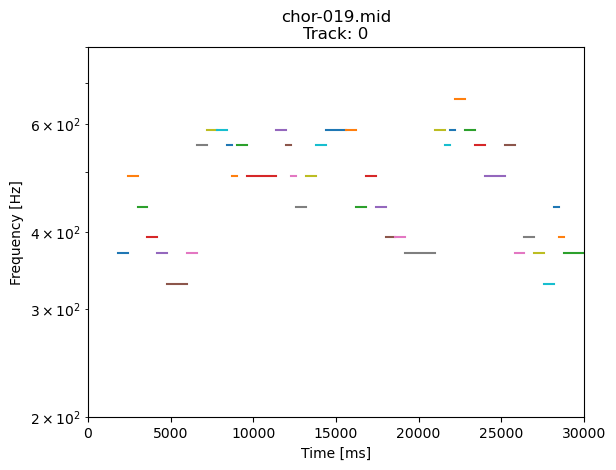

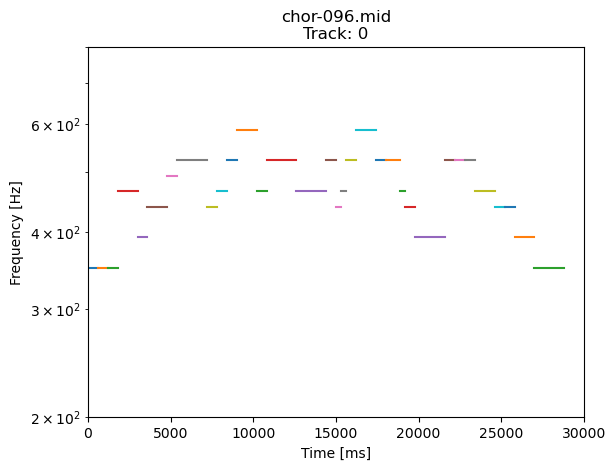

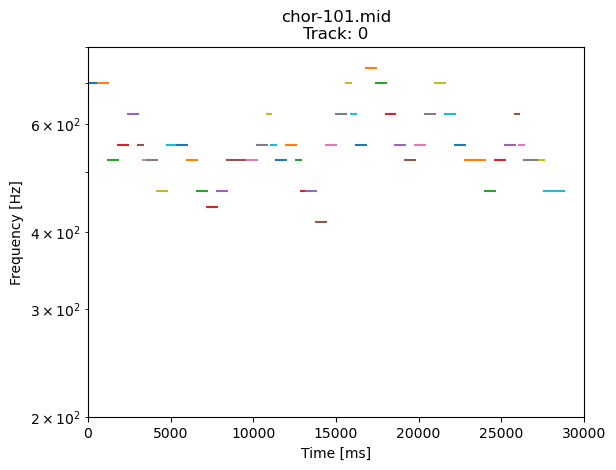

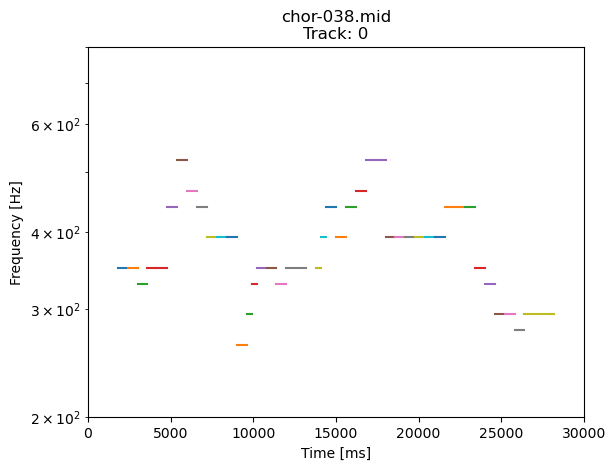

In [7]:
import librosa
import matplotlib.pyplot as plt


note_labels = {} # map notes to midi values
notes = {} # collects all notes in a song

for song in song_book:
    notes[song] = []
    tracks = song_book[song]
    
    for track in tracks:
        events = song_book[song][track]
        
        plt.figure()
        plt.title(f'{song}\nTrack: {track}')
        
        for event in events:
            # print(event)
            
            NOTE = event[0]
            START_TIME_ms = event[1]
            STOP_TIME_ms = event[2]
            
            FREQ_Hz = librosa.midi_to_hz(NOTE)
            # print(event)
            plt.plot([START_TIME_ms, STOP_TIME_ms], [FREQ_Hz, FREQ_Hz])

            note_label = librosa.midi_to_note(NOTE)
            if note_label not in note_labels.keys():
                note_labels[note_label] = NOTE
                
            notes[song].append(note_label)
            
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [ms]')
        plt.xlim([0, 30000])
        plt.ylim([200, 800])
        plt.yscale('log')

In [8]:
note_labels

{'F♯4': 66,
 'B4': 71,
 'A4': 69,
 'G4': 67,
 'E4': 64,
 'C♯5': 73,
 'D5': 74,
 'E5': 76,
 'F4': 65,
 'A♯4': 70,
 'C5': 72,
 'F5': 77,
 'D♯5': 75,
 'G♯4': 68,
 'F♯5': 78,
 'C4': 60,
 'D4': 62,
 'C♯4': 61}

In [9]:
for song in [
    'chor-038.mid',
    'chor-096.mid',
    'chor-101.mid',
    'chor-019.mid',
]:
    print('='*50)
    print(song)
    print(notes[song])
    print('Unique:', sorted(set(notes[song])))

chor-038.mid
['F4', 'F4', 'E4', 'F4', 'A4', 'C5', 'A♯4', 'A4', 'G4', 'G4', 'G4', 'C4', 'D4', 'E4', 'F4', 'F4', 'E4', 'F4', 'F4', 'G4', 'A4', 'G4', 'A4', 'A♯4', 'C5', 'G4', 'G4', 'G4', 'G4', 'G4', 'G4', 'A4', 'A4', 'F4', 'E4', 'D4', 'D4', 'C♯4', 'D4']
Unique: ['A4', 'A♯4', 'C4', 'C5', 'C♯4', 'D4', 'E4', 'F4', 'G4']
chor-096.mid
['F4', 'F4', 'F4', 'A♯4', 'G4', 'A4', 'B4', 'C5', 'A4', 'A♯4', 'C5', 'D5', 'A♯4', 'C5', 'A♯4', 'C5', 'A4', 'A♯4', 'C5', 'D5', 'C5', 'C5', 'A♯4', 'A4', 'G4', 'C5', 'C5', 'C5', 'A♯4', 'A4', 'A4', 'G4', 'F4']
Unique: ['A4', 'A♯4', 'B4', 'C5', 'D5', 'F4', 'G4']
chor-101.mid
['F5', 'F5', 'C5', 'C♯5', 'D♯5', 'C♯5', 'C5', 'C5', 'A♯4', 'C♯5', 'C♯5', 'C5', 'A♯4', 'A4', 'A♯4', 'C5', 'C5', 'C♯5', 'D♯5', 'C♯5', 'C5', 'C♯5', 'C5', 'A♯4', 'A♯4', 'G♯4', 'C♯5', 'D♯5', 'F5', 'D♯5', 'C♯5', 'F♯5', 'F5', 'D♯5', 'C♯5', 'C5', 'C♯5', 'D♯5', 'F5', 'D♯5', 'C♯5', 'C5', 'A♯4', 'C5', 'C♯5', 'D♯5', 'C♯5', 'C5', 'C5', 'A♯4']
Unique: ['A4', 'A♯4', 'C5', 'C♯5', 'D♯5', 'F5', 'F♯5', 'G♯4']
chor-0

F major https://en.wikipedia.org/wiki/F_major

F, G, A, B♭, C, D, and E
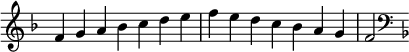

B-flat minor 
https://en.wikipedia.org/wiki/B-flat_minor

B♭, C, D♭, E♭, F, G♭, and A♭
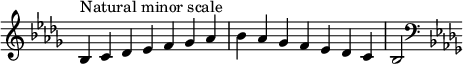

B minor https://en.wikipedia.org/wiki/B_minor

B, C♯, D, E, F♯, G, and A
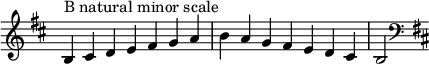

In [10]:
# note orders from Wikipedia
note_diff = {
    'chor-038': # F major: F, G, A, B♭, C, D, and E
    {
        'C4': -3,
        'C♯4': -2.5, 
        'D4': -2, 
        'E4': -1, 
        'F4': 0, 
        'G4': 1,
        'A4': 2, 
        'A♯4': 3, # B♭
        'C5': 4, 
    },
    'chor-096': # F major: F, G, A, B♭, C, D, and E
    {
        'F4': 0, 
        'G4': 1,
        'A4': 2, 
        'A♯4': 3, # B♭
        'B4': 4, 
        'C5': 5, 
        'D5': 6, 
    },
    'chor-101': # B-flat minor: B♭, C, D♭, E♭, F, G♭, and A♭
    {
        'G♯4': -2,# A♭
        'A4': -0.5, 
        'A♯4': 0, # B♭
        'C5': 1, 
        'C♯5': 2, # D♭
        'D♯5': 3, # E♭
        'F5': 4, 
        'F♯5': 5, # G♭
    },
    'chor-019': # B minor: B, C♯, D, E, F♯, G, and A
    {
        'E4': -4, 
        'F♯4': -3,
        'G4': -2,
        'A4': -1, 
        'B4': 0, 
        'C♯5': 1, 
        'D5': 2, 
        'E5': 3,
    }
}

note_diff

{'chor-038': {'C4': -3,
  'C♯4': -2.5,
  'D4': -2,
  'E4': -1,
  'F4': 0,
  'G4': 1,
  'A4': 2,
  'A♯4': 3,
  'C5': 4},
 'chor-096': {'F4': 0, 'G4': 1, 'A4': 2, 'A♯4': 3, 'B4': 4, 'C5': 5, 'D5': 6},
 'chor-101': {'G♯4': -2,
  'A4': -0.5,
  'A♯4': 0,
  'C5': 1,
  'C♯5': 2,
  'D♯5': 3,
  'F5': 4,
  'F♯5': 5},
 'chor-019': {'E4': -4,
  'F♯4': -3,
  'G4': -2,
  'A4': -1,
  'B4': 0,
  'C♯5': 1,
  'D5': 2,
  'E5': 3}}

In [11]:
import os
for song in song_book:
    tracks = song_book[song]
    song_id = song.split('\\')[-1].split('.')[0]  # extract just the name of the song
    print(song_id)

    for track in tracks.keys():
        events = tracks[track]

        np.save(os.getcwd()+'\\events_array_'+song_id, events)
tracks[0]

chor-019
chor-096
chor-101
chor-038


[[65, 1800.0, 2400.0],
 [65, 2400.0, 3000.0],
 [64, 3000.0, 3600.0],
 [65, 3600.0, 4800.0],
 [69, 4800.0, 5400.0],
 [72, 5400.0, 6000.0],
 [70, 6000.0, 6600.0],
 [69, 6600.0, 7200.0],
 [67, 7200.0, 7800.0],
 [67, 7800.0, 8400.0],
 [67, 8400.0, 9000.0],
 [60, 9000.0, 9600.0],
 [62, 9600.0, 9900.0],
 [64, 9900.0, 10200.0],
 [65, 10200.0, 10800.0],
 [65, 10800.0, 11400.0],
 [64, 11400.0, 12000.0],
 [65, 12000.0, 13200.0],
 [65, 13800.0, 14100.0],
 [67, 14100.0, 14400.0],
 [69, 14400.0, 15000.0],
 [67, 15000.0, 15600.0],
 [69, 15600.0, 16200.0],
 [70, 16200.0, 16800.0],
 [72, 16800.0, 18000.0],
 [67, 18000.0, 18600.0],
 [67, 18600.0, 19200.0],
 [67, 19200.0, 19800.0],
 [67, 19800.0, 20400.0],
 [67, 20400.0, 21000.0],
 [67, 21000.0, 21600.0],
 [69, 21600.0, 22800.0],
 [69, 22800.0, 23400.0],
 [65, 23400.0, 24000.0],
 [64, 24000.0, 24600.0],
 [62, 24600.0, 25200.0],
 [62, 25200.0, 25800.0],
 [61, 25800.0, 26400.0],
 [62, 26400.0, 28200.0]]